In [1]:
%matplotlib inline
#%matplotlib notebook

import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy import spatial
from Bio import pairwise2
from tqdm import tqdm
from glob import glob

if '../' not in sys.path:
    sys.path.append('../')

from utils import number2patten
from utils import multisize_patten2number, number2multisize_patten
from utils import slice_out_kmer

#sns.set(style='ticks')
sns.set_style('whitegrid')

### Load Embeddings

In [2]:
kmer_sizes = np.array([3, 4, 5, 6, 7, 8])

glob_str = '../max8_min3_mers_30padding_300embedding/max8_min3_mers_30padding_300embedding_epoch1_batch*.npy'
emb_files = {int(f.rstrip('.npy').split('batch')[1]): f for f in glob(glob_str)}
latest_emb_file = emb_files[sorted(emb_files)[-1]]
print(latest_emb_file)

kmer_emb = np.load(latest_emb_file)
print('All:', kmer_emb.shape)

../max8_min3_mers_30padding_300embedding/max8_min3_mers_30padding_300embedding_epoch1_batch177000000.npy
All: (87360, 300)


### Computing Nedleman-Wunsch Score and Cosine Distance

In [3]:
def get_rnd_comb(kmer_size, **kwargs):
    num_kmers = np.arange(4**kmer_size)
    comb = np.random.choice(num_kmers, (kwargs['size'], 2), replace=True)
    return comb


def get_comb(kmer_size, **kwargs):
    num_kmers = 4**kmer_size
    for i in range(0, num_kmers):
        for ii in range(i+1, num_kmers):
            yield i, ii


def compute_scores(kmer_embeddings, kmer_size, max_kmer_size=3, 
                   new_global_align=False, new_cosine_similarity=False):
    
    np_files = {
        'global_align': 'global_align_scores_{}-mers'.format(kmer_size),
        'cosine_similarity': 'cosine_similarity_{}-mers'.format(kmer_size)
    }
    
    if kmer_size > max_kmer_size:
        combinations = (((4**max_kmer_size)**2) - 4**max_kmer_size) // 2
        comb_fn = get_rnd_comb
    else:
        combinations = (((4**kmer_size)**2) - 4**kmer_size) // 2
        comb_fn = get_comb
    
    global_align_exist = os.path.isfile(np_files['global_align'] + '.npy')
    cosine_sim_exist = os.path.isfile(np_files['cosine_similarity'] + '.npy')
    
    done = 0
    
    if global_align_exist and not new_global_align:
        global_align_scores = np.load(np_files['global_align'] + '.npy')
        done += 1
    else:
        global_align_scores = np.zeros(combinations, dtype=np.int8)

    if cosine_sim_exist and not new_cosine_similarity:
        cosine_similarity = np.load(np_files['cosine_similarity'] + '.npy')
        done += 1
    else:
        cosine_similarity = np.zeros(global_align_scores.size)

    if done < 2:
        for i, (num_seq1, num_seq2) in tqdm(enumerate(comb_fn(kmer_size, size=combinations)), 
                                            total=combinations,
                                            desc='{}-mer'.format(kmer_size),
                                            file=sys.stdout):
        
            seq1 = number2patten(num_seq1, kmer_size)
            seq2 = number2patten(num_seq2, kmer_size)
        
            if not global_align_exist or new_global_align:
                global_align_scores[i] = max([align[2] for align in pairwise2.align.globalxx(seq1, seq2)])
            
            if not cosine_sim_exist or new_cosine_similarity:
                cosine_similarity[i] = 1 - spatial.distance.cosine(kmer_embeddings[num_seq1], 
                                                                   kmer_embeddings[num_seq2])
            
        if not global_align_exist or new_global_align:
            np.save(np_files['global_align'], global_align_scores)
        if not cosine_sim_exist or new_cosine_similarity:
            np.save(np_files['cosine_similarity'], cosine_similarity)
    
    return pd.DataFrame(data={'global_align_scores': global_align_scores,
                              'cosine_similarity': cosine_similarity})


# Look at all kmer sizes
for kmer_size in kmer_sizes:
    
    emb = slice_out_kmer(kmer_emb, kmer_size, min(kmer_sizes), max(kmer_sizes))
    kmer_df = compute_scores(emb, kmer_size, max_kmer_size=4,
                             new_global_align=True, new_cosine_similarity=True)
    kmer_df['kmer_size'] = kmer_size
    
    if kmer_size == kmer_sizes[0]:
        all_kmer_df = kmer_df.copy()
    else:
        all_kmer_df = all_kmer_df.append(kmer_df, ignore_index=True)

8-mer: 100%|██████████| 32640/32640 [02:51<00:00, 190.13it/s]


In [4]:
from collections import Counter
Counter(all_kmer_df['kmer_size'])

Counter({3: 2016, 4: 32640, 5: 32640, 6: 32640, 7: 32640, 8: 32640})

### Plotting  Nedleman-Wunsch Score vs. Emb. Cosine Distance

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


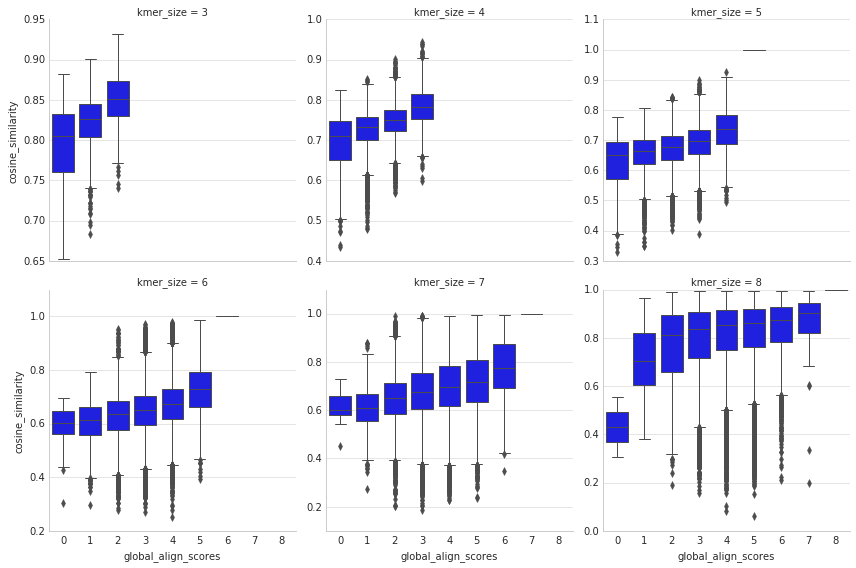

In [5]:
#sns.violinplot(x='global_align_scores', y='cosine_similarity', hue='kmer_size', data=all_kmer_df)

g = sns.FacetGrid(all_kmer_df, col='kmer_size', size=4, aspect=1, col_wrap=3, sharey=False)
#g = g.map(sns.violinplot, 'global_align_scores', 'cosine_similarity')
g = g.map(sns.boxplot, 'global_align_scores', 'cosine_similarity')

plt.show()

In [ ]:
# Perfect match
seq1 = 'CAGCA'
seq2 = 'CAGCA'
print(pairwise2.align.globalxx(seq1, seq2))

# One mm
seq1 = 'CACCA'
seq2 = 'CAGCA'
print(pairwise2.align.globalxx(seq1, seq2))

In [6]:
def euclidean_distance(embs, vector):
    return np.sqrt(np.sum((embs - vector) ** 2, axis=1))


def get_nn(emb, min_length, max_length, nearest_neighbors=5):
    return [number2multisize_patten(seq_num, min_length, max_length) for seq_num in 
            euclidean_distance(kmer_emb, emb).argsort()[:nearest_neighbors]]


def add_emb(seq1, seq2, min_length, max_length, nearest_neighbors=5):
    seq1_emb = kmer_emb[multisize_patten2number(seq1, min_length, max_length)]
    seq2_emb = kmer_emb[multisize_patten2number(seq2, min_length, max_length)]    
    return get_nn(seq1_emb + seq2_emb, min_length, max_length, nearest_neighbors)
    

def subtract_emb(seq1, seq2, min_length, max_length, nearest_neighbors=5):
    seq1_emb = kmer_emb[multisize_patten2number(seq1, min_length, max_length)]
    seq2_emb = kmer_emb[multisize_patten2number(seq2, min_length, max_length)]    
    return get_nn(seq1_emb - seq2_emb, min_length, max_length, nearest_neighbors)


print(add_emb('ATG', 'TCC', 3, 8, 10))

test = subtract_emb('AAAA', 'TTTT', 3, 8, 10)[0]
print(add_emb(test, 'GGGG', 3, 8, 10))


['ATG', 'TCC', 'TCGGTACG', 'TACGCGTT', 'ATCGCGTA', 'CGTACGAC', 'CCGACGAT', 'TATTCGCG', 'CCGTACGA', 'CGTCGAAC']
['CAAAA', 'CAAAAA', 'GCGACGAA', 'GGGG', 'CAAAAAA', 'CAAAAAAG', 'TACGCGAC', 'CGTCGCAA', 'GGG', 'AAAACGCG']


### Example On Euclidean Distance

In [ ]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])

b = np.array([4, 4, 6])

print(a - b)

dist = np.sqrt(np.sum((a - b)**2, axis=1))
print(dist)
print(dist.argsort())

In [ ]:
def get_rnd_comb(kmer_size, **kwargs):
    num_kmers = np.arange(4**kmer_size)
    end_comb = np.random.choice(num_kmers, (kwargs['size'], 2), replace=True)
    
    return end_comb


#for i, (num_seq1, num_seq2) in enumerate(get_rnd_comb(8, size=10)):
#    print(i, num_seq1, num_seq2)

t = get_rnd_comb(3, size=10)

In [ ]:
t[t[:, 0] != t[:, 1]]